In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from Dataloader import prepare_data_loader
from Models import ConvAutoencoder

In [10]:
training_data_dir = './data/lunar/training/data/S12_GradeA/'
training_labels_file = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'

train_loader = prepare_data_loader(overlap=0.25, window_length=1, decimation_factor=3, spect_nfft=128, spect_nperseg=128, batch_size=128, data_dir = training_data_dir, labels_file_path=training_labels_file)

Starting number of files:76
Number of uniques files:71
2.2656688522307293e-47 2.5975010733668863e-14
-0.021134502099059545 485.80128524581386
(6633, 65, 70)
(6633,)
Number of windows with seismic event 299
Noise sample weight: 0.04507764209256747
Event sample weight: 0.9549223579074325


In [3]:
class Encoder(nn.Module):
    def __init__(self, hidden_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=4, stride=1, padding=1)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(3, 2, kernel_size=5, stride=1, padding=1)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(480, 20)  
        self.fc2 = nn.Linear(20, hidden_size)      
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool_1(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = self.fc1(x.reshape(x.shape[0],-1))
        x = self.relu(x)
        x = self.fc2(x)
        # print(x.shape)
        x = self.tanh(x)

        return x

class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder, self).__init__()        
        self.conv1 = nn.ConvTranspose2d(2, 3, 
							kernel_size=5, 
							stride=2, 
							padding=1, 
							output_padding=1)
        self.conv2 = nn.ConvTranspose2d(3, 1, 
							kernel_size=[4, 5], 
							stride=2, 
							padding=1, 
							output_padding=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(hidden_size, 20)
        self.fc2 = nn.Linear(20, 480)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        x = x.reshape(-1, 2, 15, 16)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x


class ConvAutoencoder(nn.Module):
    def __init__(self, hidden_size):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def save_encoder(self, path):
        torch.save(self.encoder.state_dict(), path)

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        # loss_contrastive = torch.mean((label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [ ]:
# model = Autoencoder()
model = ConvAutoencoder(hidden_size=2)

#load model
model.load_state_dict(torch.load('./models/witek_autoencoder.pth'))

In [5]:
height, width = train_loader.dataset.tensors[0].shape[1:]

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


ConvAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc): Linear(in_features=2176, out_features=100, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(16, 1, kernel_size=(4, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (fc1): Linear(in_features=100, out_features=2176, bias=True)
  )
)

In [16]:
# # Define the loss function and optimizer
# criterion = nn.L1Loss()
# # criterion = nn.KLDivLoss(reduction='batchmean')
# # criterion = nn.KLDivLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00005)

# # Train the autoencoder
# num_epochs = 100
# for epoch in range(num_epochs):
# 	epoch_loss = 0
# 	epoch_recon_loss = 0
# 	epoch_stretch_loss = 0
# 	for data in train_loader:
# 		img, _ = data
# 		img = img.reshape(-1,1,height, width).to(device)
# 		optimizer.zero_grad()
# 		output = model(img)
# 		embd_space = model.encoder(img)
# 		recon_loss = criterion(output, img)
# 		# stretch_loss = torch.abs(torch.mean(1-(embd_space[:,0]*embd_space[:,0] + embd_space[:,1]*embd_space[:,1])))
# 		# loss = recon_loss+0.0*stretch_loss
# 		# loss.backward()
# 		recon_loss.backward()
# 		# epoch_loss += loss.item()
# 		epoch_recon_loss += recon_loss.item()
# 		# epoch_stretch_loss += stretch_loss.item()
# 		optimizer.step()
# 	if epoch % 5== 0:
# 		# print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_recon_loss:.4f}')
# 		print(f'Epoch [{epoch+1}/{num_epochs}], Recon Loss: {epoch_recon_loss:.4f}, Stretch Loss: {epoch_stretch_loss:.4f}')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the loss functions and optimizer
criterion_recon = nn.L1Loss()
contrastive_loss_fn = ContrastiveLoss(margin=0.5)  # Set margin as needed
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Train the autoencoder
num_epochs = 200
for epoch in range(num_epochs):
    epoch_recon_loss = 0
    epoch_contrastive_loss = 0
    epoch_total_loss = 0

    for img, labels, ev_type in train_loader:
        img = img.reshape(-1, 1, height, width).to(device)
        
        optimizer.zero_grad()
        
        # Forward pass through the model
        output = model(img)
        embd_space = model.encoder(img)
        
        # Reconstruction loss
        recon_loss = criterion_recon(output, img)
        
        # Dynamic pairing for contrastive loss (random pairing for simplicity here)
        # Assume you generate pairs of (embd_space1, embd_space2) and corresponding labels (0 for similar, 1 for dissimilar)
        batch_size = embd_space.size(0)
        embd_space1 = embd_space
        embd_space2 = embd_space[torch.randperm(batch_size)]  # Randomly shuffle to create pairs
        contrastive_labels = (labels != labels[torch.randperm(batch_size)]).float().to(device)  # 1 if dissimilar, 0 if similar

        # Contrastive loss
        contrastive_loss = contrastive_loss_fn(embd_space1, embd_space2, contrastive_labels)

        # Total loss: reconstruction + contrastive
        total_loss = recon_loss + 0.2 * contrastive_loss

        total_loss.backward()
        optimizer.step()
        
        epoch_recon_loss += recon_loss.item()
        epoch_contrastive_loss += contrastive_loss.item()
        epoch_total_loss += total_loss.item()

    if epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Recon Loss: {epoch_recon_loss:.4f}, Contrastive Loss: {epoch_contrastive_loss:.4f}, Total Loss: {epoch_total_loss:.4f}')


Epoch [1/100], Loss: 10.1745
Epoch [2/100], Loss: 10.1348


<Figure size 1600x1200 with 0 Axes>

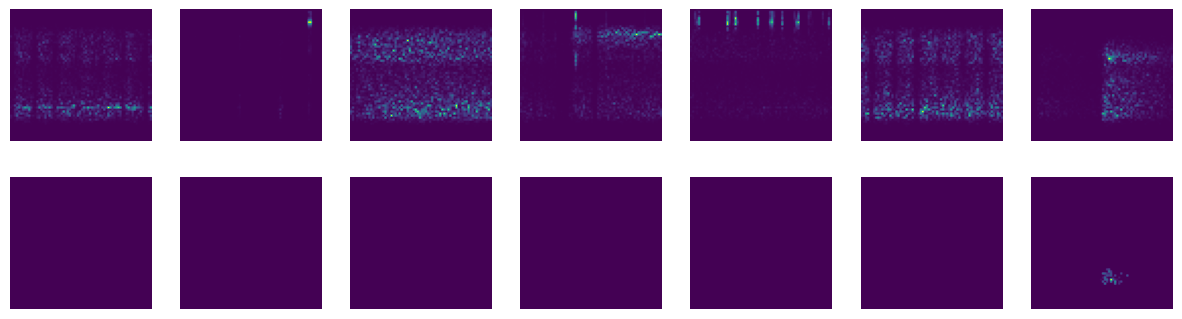

In [33]:
with torch.no_grad():
	for data, _, _ in train_loader:
		data = data.reshape(-1,1,height, width).to(device)
		recon = model(data)
		break
		
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
	ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
	ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
	ax[0, i].axis('OFF')
	ax[1, i].axis('OFF')
plt.show()

tensor(True)


<Figure size 1000x400 with 0 Axes>

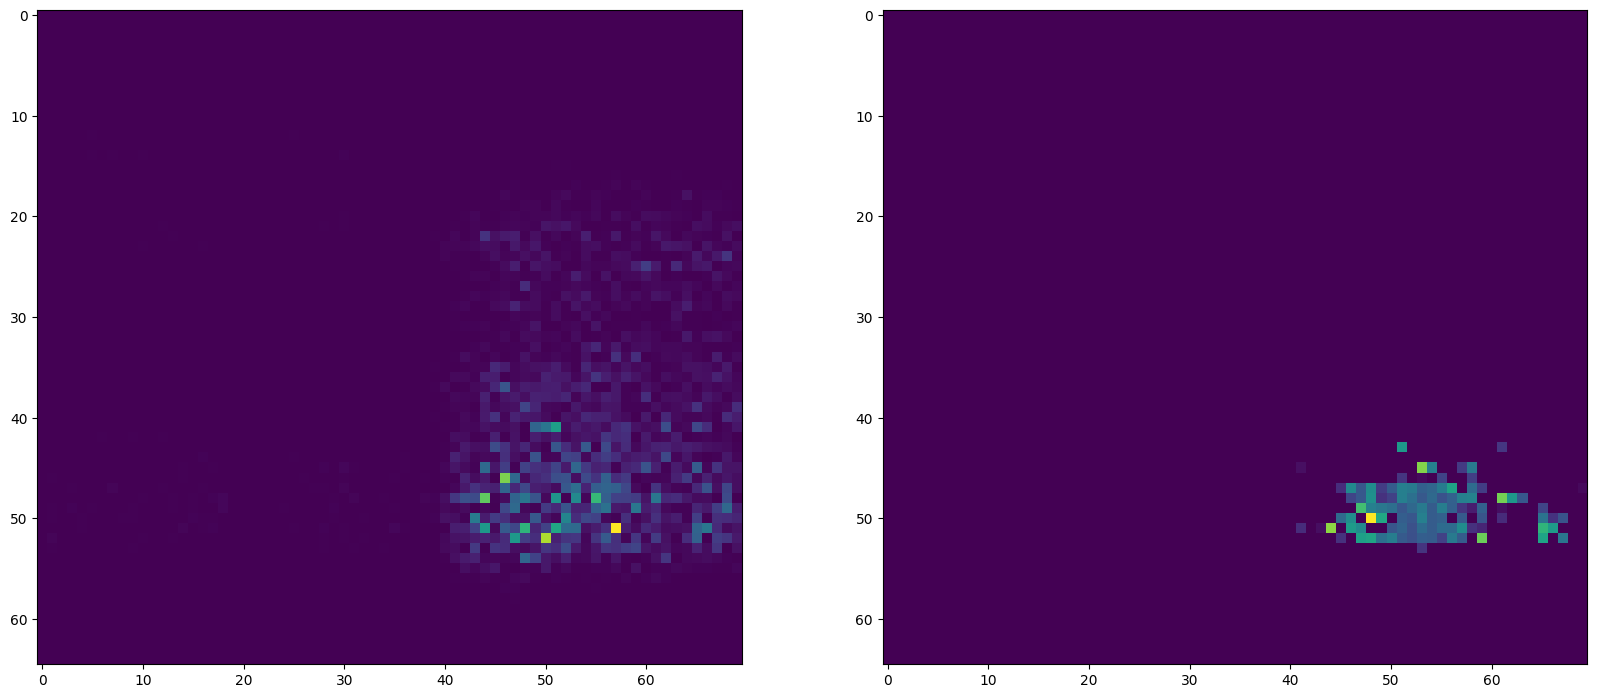

In [43]:
plt.figure(figsize=(10, 4))
model.eval()
with torch.no_grad():
    img, label, ev_type = next(iter(train_loader))
    img = img.reshape(-1, 1, height, width).to(device)
    output = model(img)
    # plt.imshow(output[0].cpu().numpy().squeeze())
    # plt.axis('off')
    #make subplot 2x1
    print(label[0])
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(img[0].cpu().numpy().squeeze())
    ax[1].imshow(output[0].cpu().numpy().squeeze())

In [ ]:
all_encodings, all_labels = [], []
all_ev_types = []
model.eval()
for img, labels, ev_type in train_loader:
    img = img.reshape(-1,1,height, width).to(device)
    embd = model.encoder(img)
    all_encodings.append(embd.detach().cpu())
    all_labels.append(labels)
    all_ev_types.append(ev_type)
all_encodings = torch.cat(all_encodings).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()
all_ev_types = torch.cat(all_ev_types).cpu().numpy()
print(all_encodings.shape, all_labels.shape, all_ev_types.shape)

In [ ]:
plt.figure(figsize=(16, 12))

# scatter = plt.scatter(all_encodings[:, 0], all_encodings[:, 1], c=all_labels.astype(int), cmap='tab10', s=10)
scatter = plt.scatter(all_encodings[:, 0], all_encodings[:, 1], c=all_ev_types.astype(int), cmap='Accent', s=20)

# Display legend
plt.grid(True)
# plt.xlim(-1, -0.25)
# plt.ylim(-1, -0.7)
plt.title(f'Encoder transformation of {all_encodings.shape[0]} Walidation datapoints of Classes')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# plt.colorbar(scatter)
#legend
plt.legend(*scatter.legend_elements(), title="Event")
plt.show()


In [11]:
# autoencoder.save_encoder('./models/encoder.pth')
# torch.save(model.state_dict(), "./models/witek_autoencoder_2.pth")